<h3>Algorithmic Machine Learning Challenge</h3>
<h1>Plankton Image Classification</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

Plankton comprises all the organisms freely drifting with ocean currents. These life forms are a critically important piece of oceanic ecosystems, accounting for more than half the primary production on earth and nearly half the total carbon fixed in the global carbon cycle. They also form the foundation of aquatic food webs, including those of large, commercially important fisheries. Loss of plankton populations could result in ecological upheaval as well as negative societal impacts, particularly in indigenous cultures and the developing world. Plankton’s global significance makes their population levels an ideal measure of the health of the world’s oceans and ecosystems.

Traditional methods for measuring and monitoring plankton populations are time consuming and cannot scale to the granularity or scope necessary for large-scale studies. Improved approaches are needed. One such approach is through the use of underwater imagery sensors. 

In this challenge, which was prepared in cooperation with the Laboratoire d’Océanographie de Villefranche, jointly run by Sorbonne Université and CNRS, plankton images were acquired in the bay of Villefranche, weekly since 2013 and manually engineered features were computed on each imaged object. 

This challenge aims at developing solid approaches to plankton image classification. We will compare methods based on carefully (but manually) engineered features, with “Deep Learning” methods in which features will be learned from image data alone.

The purpose of this challenge is for you to learn about the commonly used paradigms when working with computer vision problems. This means you can choose one of the following paths:

- Work directly with the provided images, e.g. using a (convolutional) neural network
- Work with the supplied features extracted from the images (*native* or *skimage* or both of them)
- Extract your own features from the provided images using a technique of your choice

You will find a detailed description about the image data and the features at the end of this text.
In any case, the choice of the classifier that you decide to work with strongly depends on the choice of features.

Please bear in mind that the purpose of this challenge is not simply to find the best-performing model that was released on e.g. Kaggle for a similar problem. You should rather make sure to understand the dificulties that come with this computer vision task. Moreover, you should be able to justify your choice of features/model and be able to explain its advantages and disadvantages for the task.

# Overview
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

Beyond simply producing a well-performing model for making predictions, in this challenge we would like you to start developing your skills as a machine learning scientist.
In this regard, your notebook should be structured in such a way as to explore the five following tasks that are expected to be carried out whenever undertaking such a project.
The description below each aspect should serve as a guide for your work, but you are strongly encouraged to also explore alternative options and directions. 
Thinking outside the box will always be rewarded in these challenges.

<div class="">
    <h2>Submission Instructions</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;" />    
</div>

- The goal of this challenge is to construct a model for predicting Plankton (taxonomy level 2) classes.

- Your submission will be the <b>HTML version of your notebook</b> exploring the various modelling aspects described above.

- At the end of the notebook you should indicate your final evaluation score on a held-out test set. As an evaluation metric you should use the F1 score with the *average=macro* option as it is provided by the scikit-learn library. See the following link for more information:
        
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

<div class="">
    <h1>Start of our Notebook</h1>
    <hr style="height:1px;border:none;color:#333;background-color:#333;" />    
</div>

For this project, we decided to try be as accurate as possible with two different approaches in order to see if there was significant differences between these 2 approaches.

The first approach is to try using existing features with different models, and the second consists in using deep learning using images only.



<h2>Librairies Import</h2>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>


In [1]:
!pip install --user imblearn
!pip install --user joblib

You are using pip version 18.0, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [25]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import zipfile
from io import BytesIO
from PIL import Image
from sklearn.utils import shuffle
import seaborn as sns

path = "/mnt/datasets/plankton/flowcam/"

In [3]:

def extract_zip_to_memory(input_zip):
    '''
    This function extracts the images stored inside the given zip file.
    It stores the result in a python dictionary.
    
    input_zip (string): path to the zip file
    
    returns (dict): {filename (string): image_file (bytes)}
    '''
    input_zip=zipfile.ZipFile(input_zip)
    return {name: BytesIO(input_zip.read(name)) for name in input_zip.namelist() if name.endswith('.jpg')}


img_files = extract_zip_to_memory(path+"imgs.zip")

#Display an example image 
Image.open(img_files['imgs/32738710.jpg'])

# Load the image as a numpy array:
np_arr = np.array(Image.open(img_files['imgs/32738710.jpg']))

# Be aware that the dictionary will occupy roughly 2GB of computer memory!
# To free this memory again, run:
# del img_files


## 1. Data Exploration




## 1.1 Data Exploration on the feature

In [2]:
metaDF = pd.read_csv(path + 'meta.csv')
taxoDF = pd.read_csv(path + 'taxo.csv')
features_nativeDF = pd.read_csv(path +"features_native.csv.gz", compression='gzip')
features_skimageDF = pd.read_csv(path +"features_skimage.csv.gz", compression='gzip')

In [3]:
metaDF.head()


,objid,projid,id,status,latitude,longitude,objdate,objtime,depth_min,depth_max,unique_name,lineage,level1,level2
0,32756761.0,133,84963,V,43.683333,7.3,2013-09-19,00:09:00,0,75,detritus,/#/not-living/detritus,detritus,detritus
1,32759364.0,133,84963,V,43.683333,7.3,2013-09-19,00:09:00,0,75,detritus,/#/not-living/detritus,detritus,detritus
2,32758055.0,133,28299,V,43.683333,7.3,2013-09-19,00:09:00,0,75,Guinardia,/#/living/Eukaryota/Harosa/Stramenopiles/Ochro...,Guinardia,Rhizosolenids
3,32758988.0,133,92010,V,43.683333,7.3,2013-09-19,00:09:00,0,75,silks,/#/not-living/plastic/other/silks,silks,silks
4,32760598.0,133,92010,V,43.683333,7.3,2013-09-19,00:09:00,0,75,silks,/#/not-living/plastic/other/silks,silks,silks


<H4>What are status, latitude longitude objdate objtime depth_min depth_max? Do they have different only one value? 

In [4]:
colums = ["projid", "id", "status", "latitude", "longitude", "objdate", "objtime", "depth_min", "depth_max", "unique_name", "lineage", "level1", "level2"]
for c in colums:
    print( c+ " has {} different value(s)".format(len(metaDF[c].unique())))

projid has 2 different value(s)
id has 103 different value(s)
status has 1 different value(s)
latitude has 1 different value(s)
longitude has 2 different value(s)
objdate has 73 different value(s)
objtime has 14 different value(s)
depth_min has 1 different value(s)
depth_max has 1 different value(s)
unique_name has 103 different value(s)
lineage has 103 different value(s)
level1 has 57 different value(s)
level2 has 40 different value(s)


<h4> We noticed that the latitude, longitude, depth_min, depth_max are always the same so it is useless to keep it. We are not going to use Level1 as it is mention above so we also drop this column.

In [5]:
metaDF.drop(columns=["latitude", "longitude", "depth_min", "depth_max", "level1"],  inplace=True)

In [6]:
metaDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243610 entries, 0 to 243609
Data columns (total 9 columns):
objid          243610 non-null float64
projid         243610 non-null int64
id             243610 non-null int64
status         243610 non-null object
objdate        243610 non-null object
objtime        243610 non-null object
unique_name    243610 non-null object
lineage        243610 non-null object
level2         242607 non-null object
dtypes: float64(1), int64(2), object(6)
memory usage: 16.7+ MB


<h4> Do we have Nan value in metaDF, in level2? if yes, we have erase it.

In [7]:
missing_numerical = metaDF.isnull().sum()
print(missing_numerical[missing_numerical > 0])

level2    1003
dtype: int64


In [8]:
metaDF.dropna(inplace=True)

In [9]:
taxoDF.head()

,levelName,id,unique_name,n,level1,comment1,level2,comment2
0,#,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,¦--living,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,¦ ¦--Bacteria,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,¦ ¦ °--Cyanobacteria,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,¦ ¦ °--Cyanophyceae,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
taxoDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 8 columns):
levelName      178 non-null object
id             103 non-null float64
unique_name    103 non-null object
n              103 non-null float64
level1         70 non-null object
comment1       7 non-null object
level2         78 non-null object
comment2       0 non-null float64
dtypes: float64(3), object(5)
memory usage: 11.2+ KB


<h4> The taxo dataframe does not give usefull info, We might not use it in this notebook.

In [11]:
features_nativeDF.head()


,objid,area,meanimagegrey,mean,stddev,min,perim.,width,height,major,...,symetriev_area,nb1_area,nb2_area,nb3_area,nb1_range,nb2_range,nb3_range,median_mean,median_mean_range,skeleton_area
0,32756761.0,6653.0,167.18,205.76,65.341,85,779.66,109,123,147.8,...,0.005988,0.017964,0.017964,0.059880,0.017647,0.017647,0.058824,47,0.276471,91.778443
1,32759364.0,1275.0,165.83,234.29,38.562,98,186.99,33,65,82.4,...,0.012048,0.024096,0.012048,0.006024,0.025478,0.012739,0.006369,21,0.133758,18.030120
2,32758055.0,2416.0,167.92,239.15,25.590,94,276.33,26,115,138.8,...,0.017857,0.011905,0.053571,0.107143,0.012422,0.055901,0.111801,16,0.099379,24.892857
3,32758988.0,1433.0,167.34,248.79,20.933,107,388.40,126,117,151.2,...,0.005988,0.000000,0.000000,0.023952,0.000000,0.000000,0.027027,6,0.040541,99.365269
4,32760598.0,1650.0,166.89,250.42,14.603,124,751.96,66,239,278.7,...,0.017964,0.029940,0.083832,0.059880,0.038168,0.106870,0.076336,5,0.038168,109.449102


In [12]:
features_nativeDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243610 entries, 0 to 243609
Data columns (total 65 columns):
objid                243610 non-null float64
area                 243610 non-null float64
meanimagegrey        243610 non-null float64
mean                 243610 non-null float64
stddev               243610 non-null float64
min                  243610 non-null int64
perim.               243610 non-null float64
width                243610 non-null int64
height               243610 non-null int64
major                243610 non-null float64
minor                243610 non-null float64
angle                243610 non-null int64
circ.                243610 non-null float64
feret                243610 non-null float64
intden               243610 non-null float64
median               243610 non-null int64
skew                 243610 non-null float64
kurt                 243610 non-null float64
%area                243610 non-null float64
area_exc             243610 non-null float64

In [13]:
print("features_nativeDF has {} object columns".format(len(features_nativeDF.select_dtypes(include=['object']).columns)))

features_nativeDF has 0 object columns


<h4> We noticed that all the features are numericals, it is a good news because, except for target of "level2", it appears that we will not have to deals with categorical varaible.

<h4> Does features_native contain Nan value? 

In [14]:
print("features_native contains Nan value: {} ".format(features_nativeDF.isnull().values.any()) )

features_native contains Nan value: True 


<h4> in which column are the Nan value?

In [15]:
missing_numerical = features_nativeDF.isnull().sum()
print(missing_numerical[missing_numerical > 0])

perimareaexc      34428
feretareaexc      34428
cdexc             34428
convarea_area      6854
symetrieh_area     6854
symetriev_area     6854
nb1_area           6854
nb2_area           6854
nb3_area           6854
skeleton_area      6854
dtype: int64


<h4> Here, as the Nan value are all in area related column we could resonably replace Nan by zero,

In [16]:
features_nativeDF = features_nativeDF.fillna(0)

In [17]:
features_skimageDF.sort_values(by=['objid']).head()

,objid,area,convex_area,eccentricity,equivalent_diameter,euler_number,filled_area,inertia_tensor0,inertia_tensor1,inertia_tensor2,...,weighted_moments_normalized6,weighted_moments_normalized7,weighted_moments_normalized8,weighted_moments_normalized9,weighted_moments_normalized10,weighted_moments_normalized11,weighted_moments_normalized12,weighted_moments_normalized13,weighted_moments_normalized14,weighted_moments_normalized15
84578,30956247.0,4836.0,5352.0,0.630302,78.469016,-2,4850.0,405.524835,-101.550224,-101.550224,...,-49.540179,93.387167,3.827137e+05,1252.539628,118.508994,0.526057,278.887140,56.974443,0.268220,0.049459
108544,30956533.0,1482.0,1614.0,0.904841,43.438934,1,1482.0,282.430835,25.810087,25.810087,...,-376.713236,-72.045882,1.205365e+06,356.407636,242.285048,0.402176,1053.688266,-310.193655,-0.083829,-0.155420
73582,30956637.0,10408.0,49589.0,0.805300,115.116798,-81,11284.0,3507.420930,1906.958383,1906.958383,...,166585.702544,-24684.957955,2.355970e+06,-97476.426271,18877.486262,-2432.200089,69036.810829,-9931.518159,1585.716397,-237.440904
41738,30956759.0,3049.0,4366.0,0.952600,62.306560,-10,3129.0,89.662486,0.350959,0.350959,...,7276.862816,-295.371753,1.317470e+05,-1179.102986,226.065417,-7.022880,-147.748105,-7.630606,2.546786,-0.142461
196868,30956825.0,804.0,1008.0,0.970620,31.995071,1,804.0,17.060549,8.584147,8.584147,...,2500.691955,-301.810980,9.825678e+04,575.088469,185.684297,0.478666,-121.696890,-15.555161,0.112799,-0.072328


<h4> Does features_native contain Nan value? 

In [18]:
missing_numerical = features_skimageDF.isnull().sum()
print(missing_numerical[missing_numerical > 0])

moments_normalized0             243610
moments_normalized1             243610
moments_normalized4             243610
weighted_moments_normalized0    243610
weighted_moments_normalized1    243610
weighted_moments_normalized4    243610
dtype: int64


<h4> In Those 6 column, every row are Nan so we just have erase it.

In [19]:
features_skimageDF.drop(columns=["moments_normalized0", "moments_normalized1", "moments_normalized4", "weighted_moments_normalized0", "weighted_moments_normalized1", "weighted_moments_normalized4"],  inplace=True)

In [20]:
print("features_skimage has {} object columns".format(len(features_skimageDF.select_dtypes(include=['object']).columns)))

features_skimage has 0 object columns


In [21]:
print("there are %s differente categories at the second level in the 243609 images (before data cleaning)" % len(metaDF.level2.unique()))

there are 39 differente categories at the second level in the 243609 images (before data cleaning)


In [22]:
print("there are %s native features and %s features from skimage" %(len(features_nativeDF.columns), len(features_skimageDF.columns)))

there are 65 native features and 60 features from skimage


<h4> How the feature are correlated ? It can help us to choose models.

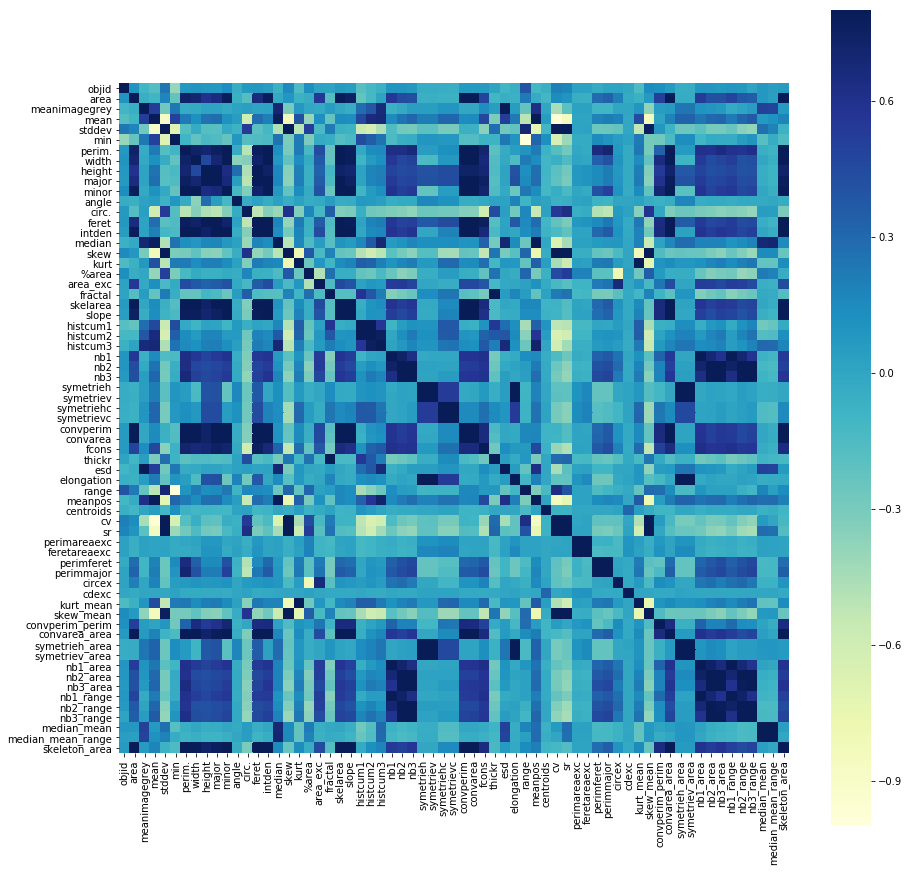

In [28]:
corr_matrix = features_nativeDF.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, vmax=.8, square=True, cmap="YlGnBu");

<h4>From this matrice we see that there are some strong linear correlation between some feature like "convperim" and "area" or "skeleton_area" and "major" but it is not a global trend.

In [25]:
nb_metaDF =  metaDF[["level2", "id"]].groupby("level2").count()
nb_metaDF = nb_metaDF.rename(index=str, columns={"id": "number"})
nb_metaDF = nb_metaDF.sort_values(by=['number'], ascending=False)
nb_metaDF

,number
level2,
detritus,138439
feces,26936
Neoceratium,14014
nauplii (Crustacea),9293
badfocus (artefact),7848
silks,5629
Copepoda,5141
Thalassionema,5117
rods,4044


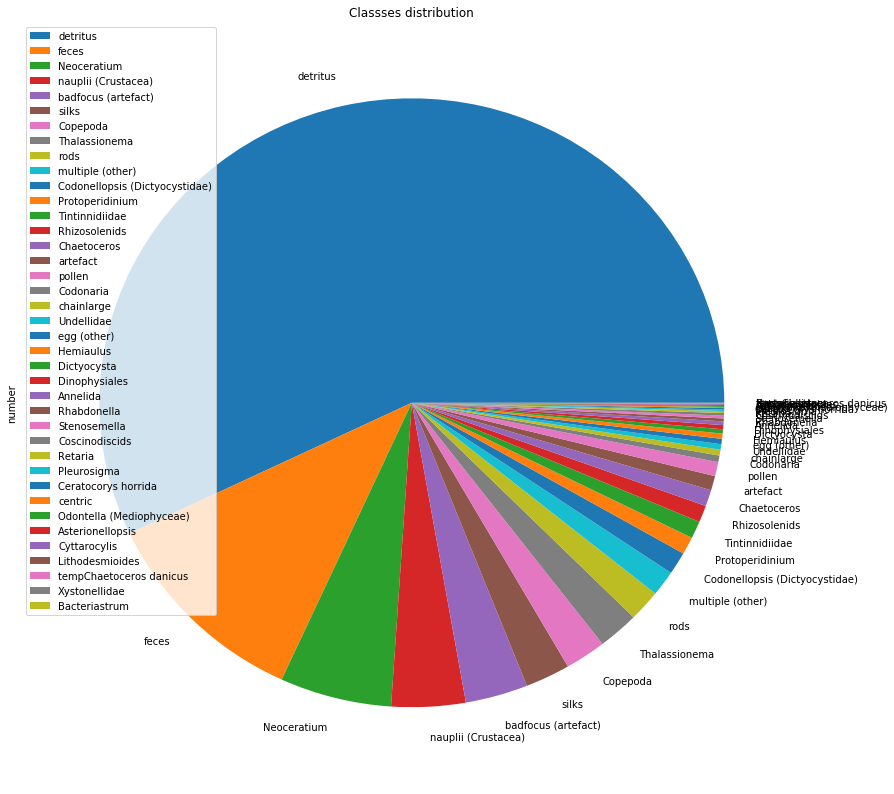

In [41]:
nb_metaDF.plot.pie(y = "number", figsize=(14,14), use_index = False, title = "Classses distribution" )


<h4> we see in this figure that the label in the dataset are not equaly distributed:
For exemple, 138439 of the photo are not-living detritus,  in other words 57% of the picture show not-living detritus.


# 1.2 data exploration on the images for convutional network




### let's have a look at the image set 

### first print some random images

imgs/32566136.jpg has a size of  (73, 107), encoded in the mode L and a format JPEG


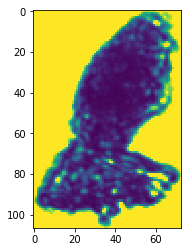

imgs/32759413.jpg has a size of  (56, 47), encoded in the mode L and a format JPEG


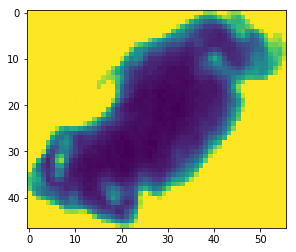

imgs/32692082.jpg has a size of  (472, 377), encoded in the mode L and a format JPEG


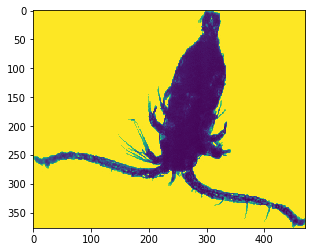

imgs/32647290.jpg has a size of  (74, 151), encoded in the mode L and a format JPEG


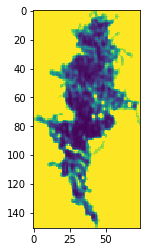

imgs/32704591.jpg has a size of  (43, 55), encoded in the mode L and a format JPEG


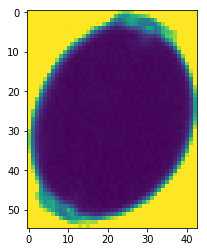

In [41]:
image_names = list(img_files.keys())
for i in range(5):
    image_name = random.choice(image_names)
    im = Image.open(img_files[image_name])
    print(image_name+ " has a size of  {}, encoded in the mode {} and a format {}".format(str(im.size),im.mode, im.format ) )
    plt.imshow(np.asarray(Image.open(img_files[image_name])))
    plt.show()
    Image.open(img_files[image_name]).show()






In [42]:
int(image_names[0].split('/')[1].split('.')[0])

32733574

<h4> All the images seems to be encoded with the mode L but have different size. Let's now have a look at the size repartition in our set, it will help us to choose how to resize our images <h4>

In [43]:
image_names = list(img_files.keys())
images_width = np.arange(len(image_names))
i = 0
for name in image_names:
    images_width[i] = Image.open(img_files[name]).width
    i += 1
print("the width distribution of the set of image has a mean of {}, a median of {}, a standart deviation of {} and coefficient of variation of {} \n the minimal  width is {} and the maximal width is {} ".format(
           np.mean(images_width), np.median(images_width) ,np.std(images_width), np.std(images_width)/np.mean(images_width), np.min(images_width), np.max(images_width)))
    

the width distribution of the set of image has a mean of 86.62893559377694, a median of 67.0, a standart deviation of 62.14625821342588 and coefficient of variation of 0.7173845296315773 
 the minimal  width is 2 and the maximal width is 972 


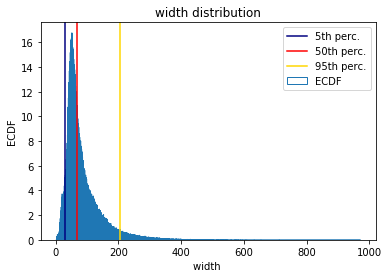

In [44]:
fig, ax = plt.subplots()
n_bins = 1000000
color = ['red', 'gold', 'chartreuse', 'm', 'navy']

# Plot the cumulative distribution
ax.hist(images_width, n_bins, density=True, histtype='step',
                           cumulative=False, label='ECDF ')
for i, quantile in enumerate([5, 50, 95]):
    
    ax.axvline(np.percentile(images_width, quantile, axis=0), label='%.0fth perc.' % (quantile), color  = color[i-1])
#ax.semilogx()
ax.set_title('width distribution')
ax.set_xlabel('width ')
ax.set_ylabel('ECDF')
ax.legend()
plt.show()
plt.show()

the width distribution of the set of image has a mean of 86.63, a median of 67.0, a standart deviation of 62.15 and coefficient of variation of 0.72
 the minimal  width is 2 and the maximal width is 972 as computed above. These informations are going to be usefull when we will resize image to use convutional network. 


In [46]:
images_height = np.arange(len(image_names))
i = 0
for name in image_names:
    images_height[i] = Image.open(img_files[name]).height
    i += 1
print("the height distribution of the set of image has a mean of {}, a median of {}, a standart deviation of {} and coefficient of variation of {}\n the minimal  height is {} and the maximal height is {} ".format(
       np.mean(images_height), np.median(images_height) ,np.std(images_height), np.std(images_height)/np.mean(images_height), np.min(images_height), np.max(images_height)))

the height distribution of the set of image has a mean of 109.33858216000985, a median of 87.0, a standart deviation of 71.93041996934804 and coefficient of variation of 0.6578685999794892
 the minimal  height is 2 and the maximal height is 739 


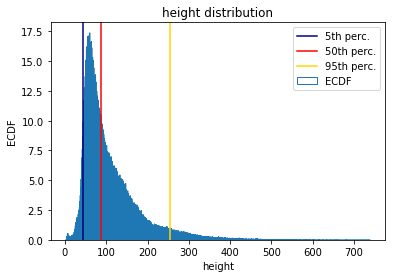

In [47]:
fig, ax = plt.subplots()
n_bins = 1000000
color = ['red', 'gold', 'chartreuse', 'm', 'navy']

# Plot the cumulative distribution
ax.hist(images_height, n_bins, density=True, histtype='step',
                           cumulative=False, label='ECDF ')
for i, quantile in enumerate([5, 50, 95]):
    
    ax.axvline(np.percentile(images_height, quantile, axis=0), label='%.0fth perc.' % (quantile), color  = color[i-1])
#ax.semilogx()
ax.set_title('height distribution')
ax.set_xlabel('height')
ax.set_ylabel('ECDF')
ax.legend()
plt.show()
plt.show()

the height distribution of the set of image has a mean of 109.33, a median of 87.0, a standart deviation of 71.930 and coefficient of variation of 0.65
 the minimal  height is 2 and the maximal height is 739 


<div class="">
    <h3>2. Data Pre-processing</h3>
</div>

### 2.1  Data Pre-processing on feature
<h4>In this part we will try to solve the issue of unbalanced data. Indeed the class distribution is unbalanced, it can influance the performance of some model. Beside for some classes, there are very few example like for Bacteriastrum. there are hardly enougth data to train a model and validate it after. We will to increase the data set size to solve this issue. Then we will check if the new added data enable improvement and if it is relevant to use it.

In [26]:
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import time

from joblib import dump, load

<h4> First we gather all our feature together. We are going to try with native and skimage feature to see which one give the best results

In [27]:
objidDF = metaDF[["objid", "level2"]]
input_data = features_nativeDF.merge(objidDF, on='objid', how='inner', sort=False)
y = input_data["level2"]
X = input_data.drop(columns=["objid", "level2"],  inplace=False)

### data using skimage

input_data_skimage = features_skimageDF.merge(objidDF, on='objid', how='inner', sort=False)
y_skimage = input_data["level2"]
X_skimage = input_data.drop(columns=["objid", "level2"],  inplace=False)

 Now let's try to solve the unballanced data set issue. First the are some categorical where we have too much data like for "detritus" and if we remove some or model will train faster and we will still have enougth (we hope ) data in order to have a good result. In the other hand for some categories we don't have enought data and we made the choice to up-sample it using the SMOTE algorithm (Synthetic Minority Oversampling Technique).
SMOTE uses the k-nearest-neighbors algorithm to create a similar, but randomly tweaked, new observations for minority category.

<h4> we remove example when there are too many data for a class

In [28]:
RANDOM_STATE = 41
list_label =  metaDF["level2"].unique()
sampling_strategy = {}
for i in range(0,39):
    if int(nb_metaDF.loc[list_label[i]]) > 3000:
        sampling_strategy[list_label[i]] = 3000
    else:
          sampling_strategy[list_label[i]] = int(nb_metaDF.loc[list_label[i]])


X_light, y_light = make_imbalance(X, y, sampling_strategy=sampling_strategy, random_state=RANDOM_STATE)
X_light_skimage, y_light_skimage = make_imbalance(X_skimage, y_skimage, sampling_strategy=sampling_strategy, random_state=RANDOM_STATE)


<h4>Some questions come up when using the SMOTE algorithm: </h4>

First, is it relevant to use it here? Indeed if a feature is very similar for a particular category (low variance), the SMOTE algorithm is going to generate a relevant synthetic feature for this class. If a feature is completly "random" for the category (hight variance), the SMOTE algorithm is going to generate a more or less "random" feature too. Finaly, SMOTE algorithm copy what it is seen in real data.
Then, is it relevant to generate 3000 synthetic datas from 12 real example? If there is too less data for a category, we choose to not generate too many data to avoid overfitting, because SMOTE algorithm copy just some particular case to generate other data.

In [29]:
#Here we choose how many synthetic data we generate for each class
for i in range(0,39):
    if  sampling_strategy[list_label[i]] < 100 :
        sampling_strategy[list_label[i]] = int(nb_metaDF.loc[list_label[i]]) * 10
    else:
        sampling_strategy[list_label[i]] = 3000


In [30]:
X_resampled, y_resampled = SMOTE(sampling_strategy=sampling_strategy).fit_resample(X_light, y_light)
X_resampled_skimage, y_resampled_skimage = SMOTE(sampling_strategy=sampling_strategy).fit_resample(X_light_skimage, y_light_skimage)

<div class="">
    <h3>2.2 Data Pre-processing for Convolutional Neural Network (CNN)</h3>
</div>

In [10]:
import os
from random import shuffle

Let's get our labels in a list.

In [11]:
metaDF['objid'] = metaDF['objid'].astype(np.int64, errors='ignore')
metaDF = metaDF.dropna(subset= ['level2'])
list_label  = list(metaDF['level2'].unique())



## Data Augmentation for underrepresented classes 


First of all we wanted to see how imbalanced was our datasets by retrieving the number of objects for each class, as it can be a problem in machine learning, especially for classes with very low number of samples.

In [12]:
for label in list_label:
        
        print(label, " has ", int(nb_metaDF.loc[label]),"images")
        

detritus  has  138439 images
Rhizosolenids  has  2160 images
silks  has  5629 images
feces  has  26936 images
Codonaria  has  845 images
Asterionellopsis  has  117 images
Codonellopsis (Dictyocystidae)  has  2888 images
Dictyocysta  has  549 images
Neoceratium  has  14014 images
Copepoda  has  5141 images
Coscinodiscids  has  334 images
nauplii (Crustacea)  has  9293 images
Protoperidinium  has  2256 images
Annelida  has  481 images
Ceratocorys horrida  has  186 images
Dinophysiales  has  525 images
Chaetoceros  has  2105 images
Thalassionema  has  5117 images
Undellidae  has  710 images
rods  has  4044 images
Hemiaulus  has  670 images
Tintinnidiidae  has  2227 images
pollen  has  1821 images
Retaria  has  257 images
multiple (other)  has  3261 images
Rhabdonella  has  367 images
chainlarge  has  751 images
artefact  has  1849 images
Pleurosigma  has  191 images
Odontella (Mediophyceae)  has  131 images
centric  has  145 images
Cyttarocylis  has  100 images
badfocus (artefact)  has  7

We see that our dataset is very skewed, with very few 'Bacteriastrum' (12) and a lot of Detritus (138439). We remove some data of the classes that are overrepresented, both to have less imbalances and faster training speed.
We choose to downsample to $7000$ images maximum arbitrarily, because we do not want to have to few data as detritus for example have a large variety of shapes and we want to keep a representative sample. 
The maximum number of samples per class could be a hyperparameter that changes our results significantly but we do not analyse it here.

In [13]:
from sklearn.utils import resample
n_samples = 7000


overrep_cat=['detritus', 'feces' , 'Neoceratium', 'badfocus (artefact)', 'nauplii (Crustacea)' ]

#overrep_cat=['detritus', 'feces' , ]


for label in overrep_cat:
    overrepDF = metaDF[metaDF['level2'] == label]
    metaDF = metaDF.drop(metaDF[metaDF["level2"] == label].index)

    

    overrepDF = resample(overrepDF, 
                                 replace=False,    # sample without replacement
                                 n_samples= n_samples,     # to match minority class
                                 random_state=123) # reproducible results
 
    # Combine minority class with downsampled majority class
    metaDF = pd.concat([metaDF, overrepDF])
    

An imbalanced data is a problem for these reasons :
- We don’t get optimized results for the classes which are unbalanced in real time as the model/algorithm never gets sufficient look at the underlying classes
- It creates a problem of making a validation or test sample as its difficult to have representation across classes in case number of observation for few classes is extremely low


<br>As the data we have is imbalanced, we will use data augmentation provided by keras to do images augmentation on fly when training our neural network. 
At first we tried to do it manually but it was not efficient and consumes memory when it is not needed.

A data generator is run in parallel to the model, for efficiency. This allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU.


<b> In addition to this data generator, we use later on $#sklearn.utils.class_weight.compute_sample_weight#$ and use it in Sequential.fit method of keras to "pay more attention" to samples from an under-represented class.</b>

In [14]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,   # used to compute quantities required for featurewise normalization (std, mean)
    featurewise_std_normalization=True,  # used to compute quantities required for featurewise normalization (std, mean)
    rotation_range=20,      #value in degrees, range within which to randomly rotate pictures
    width_shift_range=0.2,   #range (as a fraction of total width or height) within which to randomly translate pictures horizontally
    height_shift_range=0.2, #range (as a fraction of total width or height) within which to randomly translate pictures vertically
    horizontal_flip=True,   #horizontal_flip is for randomly flipping half of the images horizontally 
    vertical_flip=True)






Using TensorFlow backend.


This data generator will allow us to perform flip on both directions, rotations from angles -20 to 20 degrees, shifts ... as our data is too imbalanced.
Also we center and standardize featurewise in order to get better training results when applying our neural networks. Because of these two operations, we will also need to normalize the validation/ test data that will be our input to make predictions.

## Loading our data

We load our data images and the labels corresponding to them in a list 

In [15]:
IMG_SIZE = 50
import time

objids = list(metaDF['objid'])
labels = list(metaDF['level2'])
images=[]



for i in range (len(objids)):
    img = Image.open(img_files['imgs/'+ str(objids[i])+ '.jpg'])
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img)
    #We perform standardization and normalization in order to get better results with our neural networks
    images.append([img,labels[i]]) #Converting in float16 so that it doesn't take too much memory
    

        

#We shuffle images to have randomly distributed categories over the training data
shuffle(images)

In [16]:
""" MANUAL DATA AUGMENTATION


PIECE OF CODE WE DONT USE ANYMORE BECAUSE IT IS NOT EFFICIENT


from scipy import ndimage

min_num_images=3000

former_distribution = {}
new_distribution = {}

for label in list_label:
        
        nb_img_available = int(nb_metaDF.loc[label])
        former_distribution[label] = nb_img_available
        
        
        nb_img_final = nb_img_available
        
        if nb_img_available < min_num_images:
            i = 0
            
            
            while nb_img_final< min_num_images and i < nb_img_available : #Here we pick random images and rotate them 10 times each
                objid = metaDF[metaDF["level2"] == label].iloc[i%nb_img_available].objid
                img = Image.open(img_files['imgs/'+ str(objids[i])+ '.jpg'])
                img = img.resize((IMG_SIZE, IMG_SIZE))
                i+=1
                
                for k in range (3):
                    
                    
                    #rotate with random angle and then perform transformations
                    angle = random.randint(1,180)
                    img =  ndimage.rotate(img, angle, reshape=False, cval = 255) ## 255 to reshape in white
                    images.append([((img-np.mean(img))/np.std(img)).astype(np.float16),labels[i]])
                    
                    #flip image horizontally
                    fliplr_img = np.array(img)
                    fliplr_img = np.fliplr(fliplr_img)
                    images.append([fliplr_img, label])
                    images.append([((fliplr_img-np.mean(fliplr_img))/np.std(fliplr_img)).astype(np.float16), label])
                    
                    
                    #flip image vertically
                    flipud_img = np.array(img)
                    flipud_img = np.flipud(flipud_img)
                    images.append([((flipud_img-np.mean(flipud_img))/np.std(flipud_img)).astype(np.float16), label])
                    
                    #flip image vertically and horizontally
                    flip_img = np.array(img)
                    flip_img = np.flipud(fliplr_img)
                    images.append([((flip_img-np.mean(flip_img))/np.std(flip_img)).astype(np.float16), label])
                    
                    nb_img_final+= 4
            
            print(label, "has ", nb_img_final , " sample images after data augmentation")
        new_distribution[label] = nb_img_final
        
"""

' MANUAL DATA AUGMENTATION\n\n\nPIECE OF CODE WE DONT USE ANYMORE BECAUSE IT IS NOT EFFICIENT\n\n\nfrom scipy import ndimage\n\nmin_num_images=3000\n\nformer_distribution = {}\nnew_distribution = {}\n\nfor label in list_label:\n        \n        nb_img_available = int(nb_metaDF.loc[label])\n        former_distribution[label] = nb_img_available\n        \n        \n        nb_img_final = nb_img_available\n        \n        if nb_img_available < min_num_images:\n            i = 0\n            \n            \n            while nb_img_final< min_num_images and i < nb_img_available : #Here we pick random images and rotate them 10 times each\n                objid = metaDF[metaDF["level2"] == label].iloc[i%nb_img_available].objid\n                img = Image.open(img_files[\'imgs/\'+ str(objids[i])+ \'.jpg\'])\n                img = img.resize((IMG_SIZE, IMG_SIZE))\n                i+=1\n                \n                for k in range (3):\n                    \n                    \n      

In [17]:
#free some memory
del img_files

# 3-4 : Feature Models

<div class="">
    <h3>3. Model Selection</h3>
</div>
Perhaps the most important segment of this challenge involves the selection of a model that can successfully handle the given data and yield sensible predictions.
Instead of focusing exclusively on your final chosen model, it is also important to share your thought process in this notebook by additionally describing alternative candidate models.

The choice of your model is closely connected to the way you preprocessed the input data.

Furthermore, there are other factors which may influence your decision:

- What is the model's complexity?
- Is the model interpretable?
- Is the model capable of handling different data-types?
- Does the model return uncertainty estimates along with predictions?

- Decision Tree classifier: we try this model first because it is fast to train and easy to use as there is almost no parameter. furthermore we can use directly the feature and the categorical data. The tree used information gain to grow. Decision Tree are better to deals with non linear relationship between features. One of the advantage of decision tree is that it is interpretable.

- Logistic Regression: this model is not easy to train as it is computionaly expensive but does not have many parameter. The second problem is logistic regression is known to fail in situations where the relationship between features and outcome is nonlinear but do well when the relationship is linear.

- Gradient Boosting: This model is computionaly expensive. This Algorithm goes through cycles that repeatedly build new models using Gradient Boosted Decision Trees and combines them into an ensemble model. It is a boosting algorithm, it tries to create a strong learner from an ensemble of weak learners. It does not have many parameter : learning rate, number of iteration.



<div class="">
    <h3>4. Parameter Optimisation</h3>
</div>
Irrespective of your choice, it is highly likely that your model will have one or more (hyper-)parameters that require tuning.
There are several techniques for carrying out such a procedure, including cross-validation, Bayesian optimisation, and several others.
As before, an analysis into which parameter tuning technique best suits your model is expected before proceeding with the optimisation of your model.

If you use a neural network, the optimization of hyperparameters (learning rate, weight decay, etc.) can be a very time-consuming process. In this case, your may decide to carry out smaller experiments and to justify your choice on these preliminary tests.

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size = 0.2, stratify = y_resampled) 
X_train_no_resampled, X_val_no_resampled, y_train_no_resampled, y_val_no_resampled = train_test_split(X, y, test_size = 0.2, stratify = y)
X_train_skimage, X_val_skimage, y_train_skimage, y_val_skimage = train_test_split(X_resampled_skimage, y_resampled_skimage, test_size = 0.2, stratify = y_resampled_skimage)
# stratify = y_resampled to keep the classe proportion in the slitted data

Logistic Regression: choice of the solver
    ‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas  ‘saga’ handle L1 penalty.

### Decision Tree
we try this model first because it is fast to train and easy to use as there is almost no parameter.

In [52]:
def train_DecisionTree(X_train, y_train):
    model_tree = DecisionTreeClassifier(criterion='gini')
    t = time.time()
    model_tree.fit(X_train, y_train)
    t = time.time() -t
    return model_tree, t 

In [31]:
model_tree_1, t1 = train_DecisionTree(X_train, y_train)
print("training duration: %s s" %round(t1))

training duration: 18 s


In [93]:
y_pred_rsp = model_tree_1.predict(X_val)
score_tree_resampled_native = f1_score(y_pred_rsp, y_val, average='macro')
print("F1 score using a decision tree with the re-sampled data of native feature: %s" % score_tree_resampled_native )



F1 score using a decision tree with the re-sampled data of native feature: 0.7477716319232263


<h4> The F1 score seems quiet good for a first try with a relatively simple model, but we may interpret this with some precaution because we modify the dataset with the SMOTE algorithm. we can try to applied the model with validation data from original data to see what happen.</h4>
    
<h4>Here it is not very rigorous to use validation data from the original dataset because we train the model with the data from the SMOTE algorithm and we split the data from SMOTE in test and validation data. It may exist examples in "X_val_no_resampled" that have been used for the training model but not the majority because we remove a lot of data from the original dataset and add new one (synthetic) in X_val.</h4>
<h4>Anyway, have a look on the behaviour of the model train with synthetic data when it use the original data give an intuition of what happen, if it was relevant to balanced and add synthetic examples to train our models.

In [95]:
y_pred_nrsp = model_tree_1.predict(X_val_no_resampled)
score_tree_no_resampled = f1_score(y_pred, y_val_no_resampled, average='macro')
print("F1 score using a decision tree with the origina data of native feature: %s" % f1_score(y_pred, y_val_no_resampled, average='macro'))

F1 score using a decision tree with the origina data of native feature: 0.4019586787306226


<h4> There is a huge difference, the F1-score decrease a lot if we use the original data. to know why we futher examine the result a the F1-score function to see how each classes have been predicted.

In [ ]:
tree_table_f1 = pd.DataFrame(
    {'label': list_label,
     'score with original data': f1_score(y_pred_nrsp, y_val_no_resampled,  labels = list_label, average = None),
    'score with resampled and synthetic data': f1_score(y_pred_rsp, y_val, labels = list_label, average = None)})


In [116]:
print("detail of the score on no-resample data" )
tree_table_f1

detail of the score on no-resample data


,label,score with original data,score with resampled and synthetic data
0,detritus,0.523748,0.360134
1,Rhizosolenids,0.442211,0.663283
2,silks,0.856895,0.830610
3,feces,0.596349,0.483210
4,Codonaria,0.451039,0.741351
5,Asterionellopsis,0.235294,0.919485
6,Codonellopsis (Dictyocystidae),0.694497,0.767382
7,Dictyocysta,0.400000,0.906122
8,Neoceratium,0.715334,0.643285
9,Copepoda,0.693894,0.683209


In that table, labels are order from the most frequent to the least frequent. For some very frequent label, like detritus, the model is not very perfomant, we may have remove too much detritus from the set during the pre-prossecing, so the model does not get all the complexity of the class.
Beside, for rare classes, there are a huge difference between the validation score done with or without synthetic data. For classes like tempChaetoceros danicus or Bacteriastrum the validation scores are much higher with resampled and synthetic data than original data. How can we explain that ? maybe there are too few data to enable the SMOTE algorithm to generate reliable synthetic data for these classes.


At this stage we are wondering if training the model with synthetic data in our balanced data set is a improvement. so we are going to train a Decision tree with the original data set.

In [119]:
model_tree_2, t2 = train_DecisionTree(X_train_no_resampled, y_train_no_resampled)
print("training duration: %s" %t2)

training duration: 36.5332396030426


In [121]:
print("F1 score using a decision tree with the original data: %s" % f1_score(model_tree_2.predict(X_val_no_resampled), y_val_no_resampled, average='macro'))

F1 score using a decision tree with the original data: 0.34173081343700457


/mnt/workspace/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


we see that the F1 score with the model train with the original data is less than the previous one (0.36 against 0.4) but there is not a big difference. Using synthetic data is not a huge improvement even if it helps for rare classes as we see in the table below. The two rarest classes have a 0 score.
Moreover using the original data for the training here enable to model well detritus as there are a lot of exemple.

In [124]:
pd.DataFrame(
    {'label': list_label,
     'score with original data with a model train with original data': f1_score(model_tree_2.predict(X_val_no_resampled), y_val_no_resampled,  labels = list_label, average = None)})

/mnt/workspace/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,label,score with original data
0,detritus,0.831295
1,Rhizosolenids,0.367870
2,silks,0.808182
3,feces,0.673532
4,Codonaria,0.338983
5,Asterionellopsis,0.040000
6,Codonellopsis (Dictyocystidae),0.698523
7,Dictyocysta,0.433180
8,Neoceratium,0.711532
9,Copepoda,0.606414


Last question on Desision Tree, Is using skimage feature would help to improve?

In [127]:
model_tree_3, t3 = train_DecisionTree(X_train_skimage, y_train_skimage)
print("training duration: %s" %t3)
print("F1 score using a decision tree with skimage data: %s" % f1_score(model_tree_3.predict(X_val_skimage), y_val_skimage, average='macro'))
print("F1 score using a decision tree with original data: %s" % f1_score(model_tree_3.predict(X_val_no_resampled), y_val_no_resampled, average='macro'))

training duration: 16.500319004058838
F1 score using a decision tree with skimage data: 0.7526438566746113
F1 score using a decision tree with original data: 0.3999295223679198


<h4> Score with skimage feature and native feature are similar. Here skimage data are also resampled and synthetics data

## Logistic Regression

In the logistic regression we are going to use the same method than for Decision Tree, train model with the balance and increase data set and see how it perform on other orignal data set. We also try to train model with original data to see how it performs.

In [39]:
def LogisticRegression_training(X_train, X_val, y_train, y_val, solver, nb_iter):
    clf = LogisticRegression(random_state=0, multi_class='multinomial', solver=solver, class_weight='balanced', max_iter = nb_iter ) #The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
    t = time.time()
    model = clf.fit(X_train, y_train)
    t = time.time()-t
    y_pred = model.predict(X_val)
    score = f1_score(y_pred, y_val, average='macro')
    return model, score ,t

In [ ]:
model_lg_1, score1 ,t1 = LogisticRegression_training(X_train, X_val, y_train, y_val, 'newton-cg', 100)


In [36]:
print("F1 score using a logistic regression with the resampled data for the validtion: %s" % score1)

F1 score using a logistic regression with the resampled data for the validtion: 0.402648273672195


In [135]:
print("F1 score using a logistic regression with the origina data for the validtion: %s" % f1_score(model_lg_1.predict(X_val_no_resampled), y_val_no_resampled, average='macro'))

F1 score using a logistic regression with the origina data for the validtion: 0.205579536642283


In [ ]:
model_lg_2, score2 ,t2 = LogisticRegression_training(X_train_skimage, X_val_skimage, y_train_skimage, y_val_skimage, 'newton-cg', 100) 

In [140]:
print("training duration %s" % t2)
print("F1 score using a logistic regression training with skimage: %s" % score2)

training duration 470.6983230113983
F1 score using a logistic regression training with skimage: 0.449549614679182


In [ ]:
model3, score3 ,t3 =  LogisticRegression_training(X_train_no_resampled, X_val_no_resampled, y_train_no_resampled, y_val_no_resampled, 'newton-cg', 100)

In [143]:
print("training duration: %s seconds" % int(t3))
print("F1 score using a logistic regression training with orignal data: %s" % score3)

training duration: 1337 seconds
F1 score using a logistic regression training with orignal data: 0.2020320861566354


<h4>So far it we can noticed that logistic regression is less performant than decision tree, for both model train with original or resampled data. Futhermore if we used original dataset for validation in the model train with resample and synthetic data, it give almost the same score that with the model train with original data, it may means that using our synthetic and resampled dataset does not improve the model here. Used different set ( synthetic data vs original data) for validation and training is not rigorous but in our case it can give an intution of happen as explain above.
We see also that logistic regression is far more computionaly expensive.</h4>

<table>
   <tr>
       <th>training data used </th>
       <th> validation data used</th>
       <th>f1 score</th>
   </tr>

   <tr>
       <td>resample data</td>
       <td>resample data</td>
       <td>0.4529</td>
   </tr>
   <tr>
       <td>original data</td>
       <td>original data</td>
       <td>0.2020</td>
   </tr>
    <tr>
       <td>resample data</td>
       <td>original data</td>
       <td>0.2055</td>
   </tr>
</table>

<h4>So far we just use "newton-cg" solver, we can also try LogisticRegression with different solver to improve the  logistic regression

In [7]:
score6 = 0.16571075787303247
t6 =  240.65762162208557
model_lgt_5 = load('model5.joblib') 

In [ ]:
model_lg_5, score5 ,t5 = LogisticRegression_training(X_train, X_val, y_train, y_val, 'saga', 100)


In [6]:
print("training duration: %s seconds" % int(t5))
print("F1 score using a logistic regression with saga solver : %s" % score5)

training duration: 126 seconds
F1 score using a logistic regression with saga solver : 0.0014014042070154295


In [ ]:
model_lg_6, score6 ,t6 = LogisticRegression_training(X_train, X_val, y_train, y_val, 'lbfgs', 100)

In [8]:
print("training duration: %s seconds" % int(t6))
print("F1 score using a logistic regression with Limited-memory BFGS solver : %s" % score6)

training duration: 240 seconds
F1 score using a logistic regression with Limited-memory BFGS solver : 0.16571075787303247


<h4> It seems that the newton-cg was the best one for solving this problem, now we increase the number of iteration to see it imporves the F1-score. 

In [ ]:
model_lg_7, score7 ,t7 = LogisticRegression_training(X_train, X_val, y_train, y_val, 'newton-cg', 200)

In [61]:
print("F1 score using a logistic regression with newton-cg solver and 200 iterations : %s" % score7)

F1 score using a logistic regression with newton-cg solver and 200 iterations : 0.48888563739361973


In [49]:
model_lg_8, score8 ,t8 = LogisticRegression_training(X_train, X_val, y_train, y_val, 'newton-cg', 500)

/mnt/workspace/.local/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [62]:
print("F1 score using a logistic regression with newton-cg solver and 500 iterations : %s" % score8)

F1 score using a logistic regression with newton-cg solver and 500 iterations : 0.5342433522002815


<h4>At this stage we see that increase the number of iterations slightly increases the F1 score, but it computionaly very expensive for a worst result than for decision tree.

<h4>To conclude on this model, in our case logistic regression are computionnaly expensive and not very efficient.

## Gradient Boosting

In [63]:
def trainingGBC(X_train, y_train, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', max_depth=3):
    clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', max_depth=3) # first try with default parameter
    t = time.time()
    clf.fit(X_train, y_train)
    t = time.time()-t
    return clf, t

In [68]:
GBC_clf_1, t1 = trainingGBC(X_train, y_train, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', max_depth=3)

In [56]:
print("training duration: %s second" %int(t1))

training duration: 2427.550479412079


In [54]:
GBC_clf_2 = load("clf22.joblib")

In [58]:
y_pred = GBC_clf_1.predict(X_val)
score = f1_score(y_pred, y_val, average='macro')
print("F1 score using a Gradient Boosting train with the increase dataset: %s" % score)

F1 score using a Gradient Boosting train with the increase dataset: 0.817697364516699


In [50]:
y_pred_no_resampled = GBC_clf_1.predict(X_val_no_resampled)
score = f1_score(y_pred_no_resampled, y_val_no_resampled, average='macro')
print("F1 score using a Gradient Boosting with the original data for the validtion: %s" % score)

F1 score using a Gradient Boosting with the original data for the validtion: 0.404668020983579


In [ ]:
GBC_clf_2, t2 =  trainingGBC(X_train_no_resampled, y_train_no_resampled, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', max_depth=3)

In [57]:
print("training duration: %s second" %int(t2))

training duration: 3724 second


In [61]:
y_pred = GBC_clf_2.predict(X_val_no_resampled)
score = f1_score(y_pred, y_val_no_resampled, average='macro')
print("F1 score using a Gradient Boosting train with the original dataset: %s" % score)

F1 score using a Gradient Boosting train with the original dataset: 0.6298639117953518


<h4>Here we noticed that the model train with the original data perform well, better than the model train on the synthetic data when use on the original data.</h4>

<table>
   <tr>
       <th>training data used </th>
       <th> validation data used</th>
       <th>f1 score</th>
   </tr>

   <tr>
       <td>resample data</td>
       <td>resample data</td>
       <td>0.8176</td>
   </tr>
   <tr>
       <td>original data</td>
       <td>original data</td>
       <td>0.4046</td>
   </tr>
    <tr>
       <td>resample data</td>
       <td>original data</td>
       <td>0.6298</td>
   </tr>
</table>


<h4>Finally it appear that our data augmentation and balance were not relevant as it does not enable to train better model when dealing with gradient boosting. There may are  two reasons: First the SMOTE Algorithm does not generate relevant new data, secondly as we see for Decision Tree classifier, the distribution that we choose for the resample data during the preprocesing was not enougth relevant. For computionaly issues we remove too much data like for the detritus class. Model are not able to learn this class well because they may be too less data</h4>

<h4> we can try to optimize the learning rate to improve our gradient boosting model

In [ ]:
GBC_clf_5, t5 =  trainingGBC(X_train_no_resampled, y_train_no_resampled, loss='deviance', learning_rate=0.05, n_estimators=200, subsample=1.0, criterion='friedman_mse', max_depth=3)
GBC_clf_6, t5 =  trainingGBC(X_train_no_resampled, y_train_no_resampled, loss='deviance', learning_rate=0.05, n_estimators=500, subsample=1.0, criterion='friedman_mse', max_depth=3)

In [40]:
y_pred = GBC_clf_5.predict(X_val_no_resampled)
score = f1_score(y_pred, y_val_no_resampled, average='macro')
print("training duration: %s s" % t5)
print("F1 score using a Gradient Boosting train with the original dataset: %s" % score)

training duration: 3713.876478910446 s
F1 score using a Gradient Boosting train with the original dataset: 0.42255265116600754


In [ ]:
GBC_clf_6, t6 =  trainingGBC(X_train_no_resampled, y_train_no_resampled, loss='deviance', learning_rate=0.05, n_estimators=500, subsample=1.0, criterion='friedman_mse', max_depth=3)

In [ ]:
y_pred = GBC_clf_6.predict(X_val_no_resampled)
score = f1_score(y_pred, y_val_no_resampled, average='macro')

In [43]:
print("training duration: %s s" % round(t6))
print("F1 score using a Gradient Boosting train with the original dataset: %s" % score)

training duration: 3674 s
F1 score using a Gradient Boosting train with the original dataset: 0.42308940470066797


here our tries are not helping us to improve the model.

# 3-4: Deep Learning Model

<div class="">
    <h3>3. Model Selection</h3>
</div>

A neural network allws us to perform image classification tasks directly from the images without the need for extra features. It takes images as an entry that all have the same shape (after we do a preprocessing), it cannot take any other data type as an input.

- The advantages is that deep learning networks generally have high accuracy, fast prediction speed, they can handles lots of irrelevant features (separates signal from noise) and finally they automatically learn feature interactions.

- The drawbacks of networks is that there are not interpretable, very slow to train due to huge quantities of parameters (weights connecting different layers).


We chose a simple Convolutional Neural Network (CNN) as our DeepLearning model as it is the one commonly used to deal with image classification in deep learning. 
The one we chose is composed of 2 convolutional layers, dropout at last layer, and Pooling layers after covolutional layers in order to perform dimensionality reduction and have faster training.

Batch normalization layers are not used here as we thought it may have slowed down the training process and as we normalize our data before it enters our input layer.

We did not try other architectures because we wanted to take more time trying to tune hyperparameters that were independant from the neural network architecture and because other architectures provide unsignificant results improvement or small improvements in some cases.

The size of the convolutional layers and the kernel were chosen arbitrarily according to some models that had good performances for image classification tasks in the litterature so we decided to  give a try to the following network.





First of all, we get our training set, validation set, encode our labels as encoders for the neural network.

In [18]:
from keras.utils import to_categorical


trainImages = np.array([i[0] for i in images]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
trainLabels = np.array([i[1] for i in images])


In [19]:
del images

In [21]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list_label)

LabelEncoder()

In [22]:
trainLabels = le.transform(trainLabels) 

39


In [23]:
trainLabels = to_categorical(trainLabels)


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# we stratify in order to have classes distributed over training and validation data
X_train, X_val, y_train, y_val = train_test_split(trainImages, trainLabels, stratify = trainLabels, test_size = 0.3)


# compute quantities required for featurewise normalization (std, mean)
datagen.fit(X_train)

test_datagen = ImageDataGenerator(
    featurewise_center=True,   # used to compute quantities required for featurewise normalization (std, mean)
    featurewise_std_normalization=True,  # used to compute quantities required for featurewise normalization (std, mean)
    )

# compute quantities required for featurewise normalization (std, mean)
test_datagen.fit(X_val)





y_integers = np.argmax(y_train, axis=1)


#Estimate sample weights by class for unbalanced datasets.
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))





### Imports and Model building

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization
import numpy as np
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization

In [27]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(39, activation='softmax'))

#save initial weights in order to use the same when comparing different approaches
model.save_weights("initial_weights.h5")



In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                495680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

# 4. Parameter Tuning 

<b> For choosing the best parameters, we use the <code>class_weight</code> otpion of Sequential.fit. This can be useful to tell the model to "pay more attention" to samples from an under-represented class.</b>

## Optimizer + learning rate

We are going to chose an optimizer and set it's learning rate when needed. We want to get practical results to choose the one we will use to make sure it's the most suitable for our problem.
What we want here is a neural network that is accurate but also learns fast, therefore we just look at the 2 first epochs, so it may be that one neural network with a small learning rate is better but if it converges too slowly we will not choose it.

### - Adagrad

Adagrad is an optimizer with parameter-specific learning rates, which are adapted relative to how frequently a parameter gets updated during training. The more updates a parameter receives, the smaller the learning rate.
<br>
Here we try with a high initial learning rate, and as it adapts we do not try other learning rates.

In [27]:
# Learning Rate = 0.1
lr=0.1

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(lr=lr),
              metrics=['accuracy'])

#re-initialize the weights of the neuron
model.load_weights("initial_weights.h5")



model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),validation_data= test_datagen.flow(X_val, y_val, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=3,  class_weight= d_class_weights)

model.save('adaG.h5')

Epoch 1/3
1774/1773 [==============================] - 75s 42ms/step - loss: 3.4821 - acc: 0.0828 - val_loss: 3.0871 - val_acc: 0.1517
Epoch 2/3
1774/1773 [==============================] - 106s 60ms/step - loss: 3.3285 - acc: 0.1197 - val_loss: 2.7757 - val_acc: 0.2625
Epoch 3/3
1774/1773 [==============================] - 107s 60ms/step - loss: 3.2126 - acc: 0.1564 - val_loss: 2.7038 - val_acc: 0.2463


### - Adadelta


Adadelta is a more robust extension of Adagrad that adapts learning rates based on a moving window of gradient updates, instead of accumulating all past gradients. This way, Adadelta continues learning even when many updates have been done. Compared to Adagrad, in the original version of Adadelta you don't have to set an initial learning rate. In this version, initial learning rate and decay factor can be set, as in most other Keras optimizers.
<br>
Here we try with a high initial learning rate, and as it adapts we do not try other learning rates.

In [28]:
# Learning Rate = 5
lr=5

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(lr=lr),
              metrics=['accuracy'])


model.load_weights("initial_weights.h5")


model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),validation_data= test_datagen.flow(X_val, y_val, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=3,  class_weight= d_class_weights)
model.save('adaD05.h5')

Epoch 1/3
1774/1773 [==============================] - 109s 61ms/step - loss: 3.4495 - acc: 0.1306 - val_loss: 3.1647 - val_acc: 0.1746
Epoch 2/3
1774/1773 [==============================] - 106s 60ms/step - loss: 3.2968 - acc: 0.1517 - val_loss: 4.1184 - val_acc: 0.1882
Epoch 3/3
1774/1773 [==============================] - 108s 61ms/step - loss: 3.3952 - acc: 0.1296 - val_loss: 4.2196 - val_acc: 0.0747


### - RMSProp

RMSProp uses a moving average of squared gradients to normalize the gradient itself. Here we look at 3 different learning rates.

In [29]:
# Learning Rate = 0.0001
lr=0.0001

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=lr),
              metrics=['accuracy'])


model.load_weights("initial_weights.h5")


model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), validation_data= test_datagen.flow(X_val, y_val, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=3,  class_weight= d_class_weights)
model.save('rms0001.h5')

# Learning Rate = 0.001
lr=0.001

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=lr),
              metrics=['accuracy'])


model.load_weights("initial_weights.h5")

model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), validation_data= test_datagen.flow(X_val, y_val, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=3,  class_weight= d_class_weights)
model.save('rms001.h5')

# Learning Rate = 0.01
lr=0.01

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=lr),
              metrics=['accuracy'])


model.load_weights("initial_weights.h5")

model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), validation_data= test_datagen.flow(X_val, y_val, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=3,  class_weight= d_class_weights)
model.save('rms01.h5')

Epoch 1/3
1774/1773 [==============================] - 85s 48ms/step - loss: 3.4885 - acc: 0.0974 - val_loss: 2.7839 - val_acc: 0.2174
Epoch 2/3
1774/1773 [==============================] - 58s 33ms/step - loss: 3.3156 - acc: 0.1542 - val_loss: 2.6313 - val_acc: 0.2740
Epoch 3/3
1774/1773 [==============================] - 58s 33ms/step - loss: 3.2229 - acc: 0.1801 - val_loss: 2.5794 - val_acc: 0.2646
Epoch 1/3
1774/1773 [==============================] - 61s 34ms/step - loss: 3.3901 - acc: 0.1650 - val_loss: 2.9532 - val_acc: 0.2412
Epoch 2/3
1774/1773 [==============================] - 60s 34ms/step - loss: 3.2777 - acc: 0.1814 - val_loss: 3.4684 - val_acc: 0.2204
Epoch 3/3
1774/1773 [==============================] - 106s 60ms/step - loss: 3.3201 - acc: 0.1885 - val_loss: 3.7884 - val_acc: 0.2158
Epoch 1/3
1774/1773 [==============================] - 104s 59ms/step - loss: 6.3591 - acc: 0.0299 - val_loss: 3.5528 - val_acc: 0.0310
Epoch 2/3
1774/1773 [==============================] 

## DropOut

Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel.

During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.

In our model we added a dropout for the last hidden layer. 
Generally, a small dropout value of 20%-50% of neurons is chosen.

We try 3 different dropout values that are 0.5, 0.3 and 0.2 (the 0.5 has been tried in cells above), we use the adaDelta optimizer here

In [30]:
#Set the dropout value to 0.3
dropout=0.3
lr=5

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(39, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(lr=lr),
              metrics=['accuracy'])


model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),validation_data= test_datagen.flow(X_val, y_val, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=3,  class_weight= d_class_weights)
model.save('adaD03.h5')

Epoch 1/3
1774/1773 [==============================] - 111s 63ms/step - loss: 3.3327 - acc: 0.1596 - val_loss: 4.0957 - val_acc: 0.1959
Epoch 2/3
1774/1773 [==============================] - 107s 60ms/step - loss: 3.1502 - acc: 0.1875 - val_loss: 5.2071 - val_acc: 0.1769
Epoch 3/3
1774/1773 [==============================] - 100s 56ms/step - loss: 3.1049 - acc: 0.1784 - val_loss: 5.2753 - val_acc: 0.1778


In [31]:
#Set the dropout value to 0.2
dropout=0.2

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(39, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(lr=lr),
              metrics=['accuracy'])


model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), validation_data= test_datagen.flow(X_val, y_val, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=3,  class_weight= d_class_weights)
model.save('adaD015.h5')

Epoch 1/3
1774/1773 [==============================] - 60s 34ms/step - loss: 3.2338 - acc: 0.1498 - val_loss: 3.6777 - val_acc: 0.1994
Epoch 2/3
1774/1773 [==============================] - 60s 34ms/step - loss: 3.0487 - acc: 0.1917 - val_loss: 4.4891 - val_acc: 0.0789
Epoch 3/3
1774/1773 [==============================] - 60s 34ms/step - loss: 3.0045 - acc: 0.1920 - val_loss: 5.0186 - val_acc: 0.1150


Let's compare the F1 scores we get because it is the metrics we will use, it is more meaningful for such an imbalanced set than accuracy. In terms of training time all networks have the same order of magnitude so we will not take the time into account to chose our model.


F1 Scores for each set of hyperparameters :

In [32]:
from sklearn.metrics import f1_score

models = ['adaG.h5','adaD05.h5','adaD03.h5','adaD015.h5','rms0001.h5','rms001.h5','rms01.h5']
scores = {}
X_val_std = (X_val- np.mean(X_train))/np.std(X_train)


for NN_models in models:
    
    model= load_model(NN_models)
    y_pred = model.predict(X_val_std) #we standardize X_val using featurewise mean and std deviation of the training set
    for i in range(y_pred.shape[0]):
        pred = np.argmax(y_pred[i])
        for j in range(y_pred.shape[1]):
            y_pred[i][j] = (j == pred)

    scores[NN_models] = f1_score(y_val, y_pred, average='macro')

print('F1 Scores for our different models for just 3 epochs')
scores

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 Scores for our different models for just 3 epochs


{'adaD015.h5': 0.05558064790633469,
 'adaD03.h5': 0.07256484638810647,
 'adaD05.h5': 0.034672602845469275,
 'adaG.h5': 0.09959545375980786,
 'rms0001.h5': 0.1161247620411892,
 'rms001.h5': 0.09404895203278511,
 'rms01.h5': 0.014765048829197238}

# 5.Model Evaluation


## Deep Learning best model :

Now we are going to train our best model more in order to achieve higher scores. We chose a dropout of 0.3 RMS as RMS gives us the best score, and among the 3 dropout rates with Adadelta the best one is 0.3.

In [25]:
model = load_model('trained_adaD033.h5') #load the model with dropout=0.3 


#model.load_weights("initial_weights.h5") #initialize weights

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adagrad(),
              metrics=['accuracy'])


model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), validation_data= test_datagen.flow(X_val, y_val, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=10 , class_weight= d_class_weights)


Epoch 1/10
1996/1995 [==============================] - 129s 65ms/step - loss: 2.3571 - acc: 0.3239 - val_loss: 2.7109 - val_acc: 0.2917
Epoch 2/10
1996/1995 [==============================] - 129s 65ms/step - loss: 2.1940 - acc: 0.3353 - val_loss: 2.5564 - val_acc: 0.2984
Epoch 3/10
1996/1995 [==============================] - 129s 65ms/step - loss: 2.1568 - acc: 0.3447 - val_loss: 2.6698 - val_acc: 0.2823
Epoch 4/10
1996/1995 [==============================] - 129s 65ms/step - loss: 2.1143 - acc: 0.3573 - val_loss: 2.6754 - val_acc: 0.3101
Epoch 5/10
1996/1995 [==============================] - 128s 64ms/step - loss: 2.0683 - acc: 0.3621 - val_loss: 2.6418 - val_acc: 0.2962
Epoch 6/10
1996/1995 [==============================] - 127s 64ms/step - loss: 2.0916 - acc: 0.3662 - val_loss: 2.7184 - val_acc: 0.2901
Epoch 7/10
1996/1995 [==============================] - 129s 65ms/step - loss: 2.0622 - acc: 0.3705 - val_loss: 2.6020 - val_acc: 0.2848
Epoch 8/10
1996/1995 [===================

In [30]:
model.save('trained_adaD033.h5')

In [31]:
model = load_model('trained_adaD033.h5')

X_val_std = (X_val- np.mean(X_train))/np.std(X_train)

In [32]:
y_pred = model.predict(X_val_std)
for i in range(y_pred.shape[0]):
    pred = np.argmax(y_pred[i])
    for j in range(y_pred.shape[1]):
        y_pred[i][j] = (j == pred)

from sklearn.metrics import f1_score
f1_score(y_val, y_pred, average='macro')

0.20739938916615586

It took us around an hour ( 4 times 10 iterations with a trained network that was reloaded) to train the model that seems to converge, and we achieve a f1_score of only 20% with our model. 

In [39]:
tree_table_f1 = pd.DataFrame(
    {'label': list_label,
     'F1 score with augmented data': f1_score(y_val, y_pred,labels = le.transform(list_label), average = None)})

tree_table_f1

,F1 score with augmented data,label
0,0.172414,detritus
1,0.408043,Rhizosolenids
2,0.226698,silks
3,0.081871,feces
4,0.092879,Codonaria
5,0.068966,Asterionellopsis
6,0.291809,Codonellopsis (Dictyocystidae)
7,0.183007,Dictyocysta
8,0.279209,Neoceratium
9,0.120471,Copepoda


### Comment
We have better F1 score with less detritus and feces that are overreprensented initially, eventhough we had more accuracy for these particular classes without removing them (but here we want the best F1-score). We think that such a low score for detritus is due to the fact that we dropped a lot of them, and that they are so various that they do not necessarily share similar features. 
One way we could improve could be to merge some classes such as non living elements because they actually correspond to a large variety of objects.

# Conclusion :Best Overall Model is Gradient Boosting 

<h4> Our best model is a gradient boosting model (GBC_clf_2 in the code) train with the original dataset with a learning rate of 0.1 and n_estimators = 100, we obtain a f1 score of 0.6298639117953518.
Compared to the deep learning approach it is much more efficient in terms of training and more accurate so for this particular problem we would choose this model without hesitation.

# References

<hr style="height:1px;border:none;color:#333;background-color:#333;" />   

https://keras.io/optimizers/

[Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

[Dropout Regularization in Deep Learning Models With Keras](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)


[Image Classification Keras Tutorial: Kaggle Dog Breed Challenge](https://towardsdatascience.com/image-classification-python-keras-tutorial-kaggle-challenge-45a6332a58b8?fbclid=IwAR1db1RsYJafYpJt_DP384KefbEFoe6RIG0T6faty9bQZWrjLTmANk70N9I)

[Deep learning unbalanced training data?Solve it like this.](https://towardsdatascience.com/deep-learning-unbalanced-training-data-solve-it-like-this-6c528e9efea6)

[How to handle imbalanced classes in machine learning](https://elitedatascience.com/imbalanced-classes)

[How many images do you need to train a neural network?](https://petewarden.com/2017/12/14/how-many-images-do-you-need-to-train-a-neural-network/)



http://benanne.github.io/2015/03/17/plankton.html

https://cv-tricks.com/tensorflow-tutorial/training-convolutional-neural-network-for-image-classification/

https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

http://imbalanced-learn.org/en/stable/over_sampling.html

https://hal.inria.fr/hal-00860051/document